In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.visualization.hist import hist as fancyhist
import astroML.stats
from IPython.display import display, Latex

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 

## Time to get your hands dirty.  The transient Universe

Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]

Figure from Gezari (2021) ["Tidal Disruption Events", review](https://arxiv.org/abs/2104.14580)

![Screen%20Shot%202022-01-23%20at%2011.00.29.png](attachment:Screen%20Shot%202022-01-23%20at%2011.00.29.png)

2. Sudden flares of active galactic nuclei

Figure from  Graham et al (2021) ["A Candidate Electromagnetic Counterpart to the Binary Black Hole Merger Gravitational Wave Event S190521ga"](https://arxiv.org/abs/2006.14122)

![Screen%20Shot%202022-01-23%20at%2011.02.53.png](attachment:Screen%20Shot%202022-01-23%20at%2011.02.53.png)

3. Supernovae.

Figure from  Jha et al (2019) ["Observational Properties of Thermonuclear Supernovae
"](https://arxiv.org/abs/1908.02303)

![Screen%20Shot%202022-01-23%20at%2011.11.23.png](attachment:Screen%20Shot%202022-01-23%20at%2011.11.23.png)


### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



# Code

## Looking at the data and defining the model

Text(0, 0.5, 'Flux')

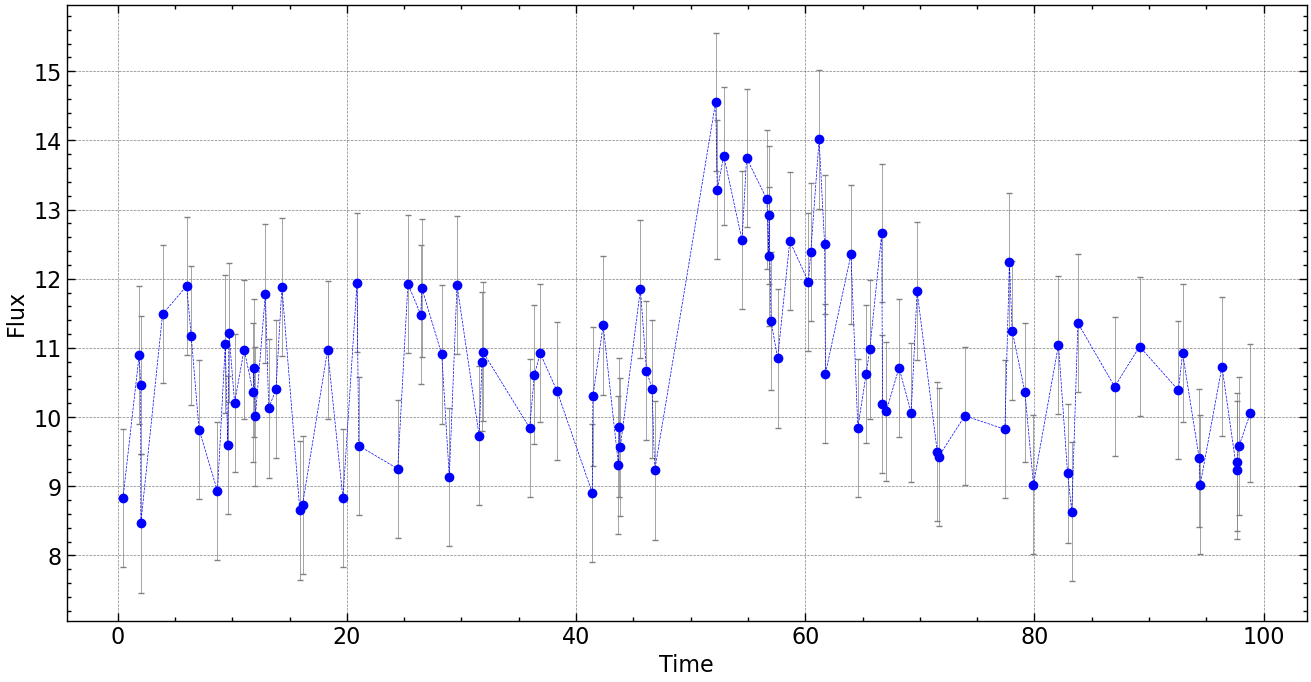

In [2]:
data = np.load('../solutions/transient.npy')
data.shape

fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, ls='--', lw=0.5)
plt.xlabel('Time')
plt.ylabel('Flux')

In [3]:
def model(x, b, A, alpha, t0):
    return np.piecewise(x, [x < t0, x >= t0], [lambda x: b, lambda x: b + A*np.exp(-alpha*(x-t0))])

[10.2878741   5.49564864  0.11890335 49.08381025]


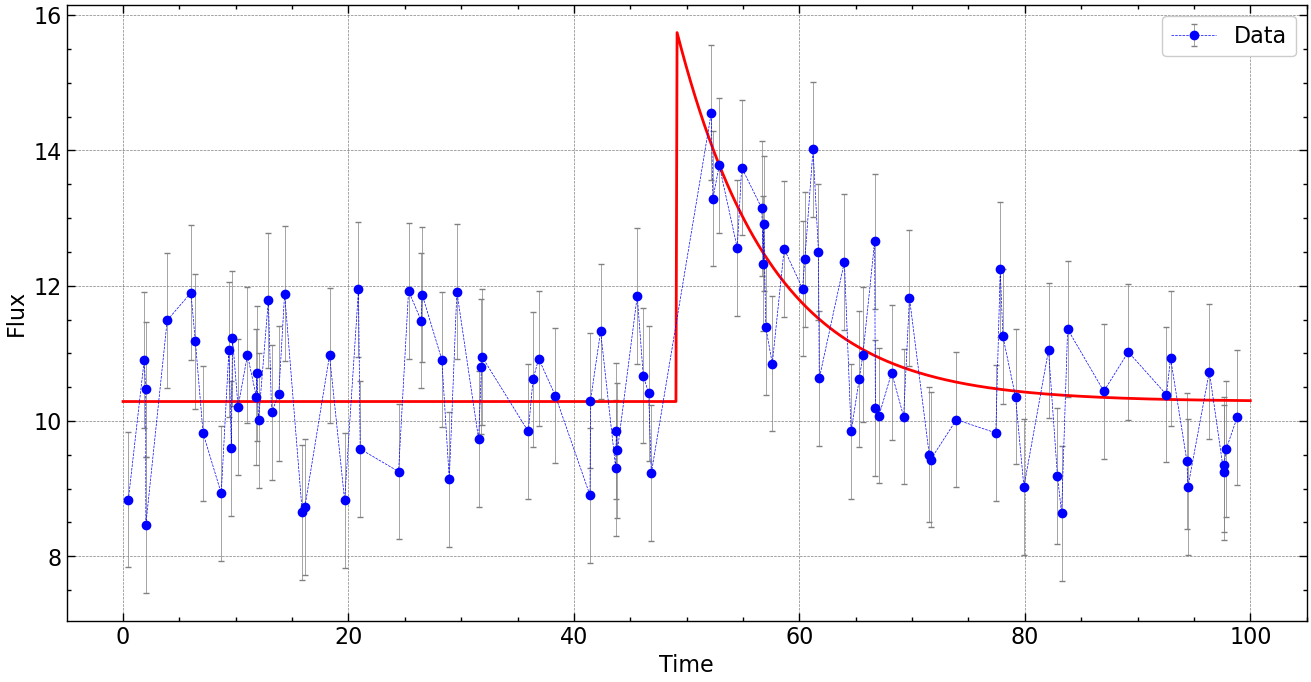

In [4]:
popt, pcov = curve_fit(model, data[:,0], data[:,1], sigma=data[:,2], p0=(10, 4, 0.05, 50), absolute_sigma=True)
print(popt)

fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, ls='--', lw=0.5, label='Data')
x_dense = np.linspace(0, 100, 1000)
plt.plot(x_dense, model(x_dense, popt[0], popt[1], popt[2], popt[3]), color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()

## Building the MCMC 